# This is the Analysis of the Wafertests



because of *filesize reasons*, you have to create the graphs locally


to create the desired graph, you need to run the following code cell and the code cell of the graphs you desire



In [ ]:
import custom_analyzer as canal
import time
import matplotlib.pyplot as plt
import custom_pathlibrary as cpath
import numpy as np
import math
from scipy.optimize import curve_fit
import scipy.optimize as fits
import functools

files = canal.get_all_filenames(startdir= "data_storage/Wafer_at_2025_06_23-11_51_07")
dataset = canal.Dataset()
dataset.add_files(files=files, only_measurements=True)

In [ ]:
print(cpath.PLib().dieNr_to_identifier)

('04E10', '04E20', '04C10', '04C20', '04E05', '04E15', '04C05', '04C15', '02E10', '02E20', '02C10', '02C20', '02E05', '02E15', '02C05', '02C15', '01E10', '01E20', '01C10', '01C20', '01E05', '01E15', '01C05', '01C15')


## 1. graphs of different types of diodes

In [3]:
### 1. graphs of different diodetypes   ###
path = cpath.PLib()
identifier = ('01C05','01C10','01C15','01E20')
plots = []
fig = plt.figure()

for i in identifier:
    slicename, slice = dataset.filter(slicename=i, parameter="identifier", value=i)
    dataset.clean_slice_data_rbias(target_slice_name=slicename, verbose=True)
    #dataset.get_slice_mean(target_slice_name=slicename)
    #dataset.get_slice_se(target_slice_name=slicename)
    getattr(dataset, "created_at")
    graph = canal.Graph(yscale="log", title=i)
    graph.unpack_dict(data=dataset.get_slice_mean(target_slice_name=slicename, rbias_only=True), mode= "x_y")
    graph.unpack_dict(data=dataset.get_slice_se(target_slice_name=slicename, rbias_only=True), mode= "x_err_y")
    fig=graph.save(to_stdout=False, close_fig=False, label=i, fig=fig)

len target_slice 0
Cleaning slice 01C05 with 0 entries


ZeroDivisionError: division by zero

<Figure size 640x480 with 0 Axes>

In [ ]:
fig.legend()
fig

## 2. Generic access

In [ ]:
ID = '01E20'
slicename, slice = dataset.filter(slicename=ID, parameter="identifier", value=ID)
dataset.clean_slice_data_rbias(target_slice_name=slicename, verbose=True)
slice = dataset.get_slice(target_slice_name = ID)

len target_slice 1341
Cleaning slice 01E20 with 1341 entries
Removing data_storage/Wafer_at_2025_06_23-11_51_07/Die_189/Subdie_18_ADiodes_1/IV_Die_189_Subdie_18_Diode_1,1_measurement_1.json from slice 01E20 due to insufficient number of rbias measurement-points (2)
Removing data_storage/Wafer_at_2025_06_23-11_51_07/Die_189/Subdie_18_ADiodes_1/IV_Die_189_Subdie_18_Diode_1,1_measurement_2.json from slice 01E20 due to insufficient number of rbias measurement-points (2)
Removing data_storage/Wafer_at_2025_06_23-11_51_07/Die_189/Subdie_18_ADiodes_1/IV_Die_189_Subdie_18_Diode_1,1_measurement_3.json from slice 01E20 due to insufficient number of rbias measurement-points (2)
Removing data_storage/Wafer_at_2025_06_23-11_51_07/Die_189/Subdie_18_ADiodes_1/IV_Die_189_Subdie_18_Diode_1,1_measurement_4.json from slice 01E20 due to insufficient number of rbias measurement-points (2)
len cleaned_t_s 1337
Yield of cleaned slice 01E20: 99.70%


In [ ]:

def arrays_from_db(db, * , include_forward = False, include_reverse = True):
    Va = []
    Ia = []
    d  = []
    if include_forward:
        d += sorted(db['iv_data_fbias'])
    if include_reverse:
        d += sorted(db['iv_data_rbias'])
    for V,I in d:
        Va.append(V)
        Ia.append(I)
    return np.array(Va, float),np.array(Ia, float)

In [ ]:
'''
From:
A model based DC analysis of SiPM breakdown voltages
Ferenc Nagy, Gyula Hegyesi, Gábor Kalinka, József Molnár
Institute for Nuclear Research, Hungarian Academy of Sciences, Bem ter 18/c, Debrecen H-4026, Hungary
https://doi.org/10.1016/j.nima.2017.01.002
term (10) (p. 4)
'''
def diode_fit(V, sig, mean, A, h):
    '''
    V > Voltage
    sig > standard deviation
    mean > mean V01 Voltage
    A > Amplitude
    h > hysteresis
    '''
    factor1 = 2 - (h/(sig**2)) * (V-mean)
    fraction_top = (V-mean) ** 2
    fraction_bottom = 2 * sig * sig
    factor2 = math.exp(-1 * (fraction_top / fraction_bottom))
    y = A * factor1 * factor2
    return y

def get_gr_1st_derivative(x ,y):
    xd = []
    yd = []
    for i in range(len(x)-1):
        xd.append((x[i]+x[i+1])/2)
        yd.append((y[i+1]-y[i])/1.)
    return xd, yd
    
def get_gr_nth_derivative(n_order, x, y):
    xd = x
    yd = y
    for i_do_deri in range(n_order):
        xd, yd = get_gr_1st_derivative(xd,yd)
    return xd,yd


**** data_storage/Wafer_at_2025_06_23-11_51_07/Die_10/Subdie_18_ADiodes_1/IV_Die_10_Subdie_18_Diode_1,1_measurement_1.json ****


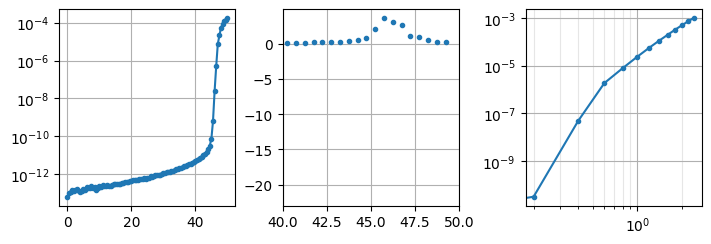

In [ ]:
for item, db in slice.items():
    print(f"**** {item} ****")
    break
#print(db)
iv = db['iv_data_fbias']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, layout='constrained', figsize=(7, 7/3))

V,I = arrays_from_db(db)
ax1.semilogy(V,I, '.-')
ax1.grid()
ax1.grid(which="minor", color="0.9")

xlogI = []
ylogI = []
for i in range(len(I)):
    if(I[i-1] <= 0):
        continue
    xlogI.append(V[i-1]) 
    ylogI.append(math.log(I[i-1]))
dlgV, dlgI = get_gr_nth_derivative(1,xlogI,ylogI)
#popt, pcov = curve_fit(diode_fit, d3V, d3I)
#print(f"popt: {popt}")
ax2.plot(dlgV,dlgI, '.')
ax2.set_xlim([40, 50])
ax2.grid()
ax2.grid(which="minor", color="0.9")

V,I = arrays_from_db(db,include_forward = True)
ax3.loglog([ -v for v in V ],[ -i for i in I ], '.-')
ax3.grid()
ax3.grid(which="minor", color="0.9")


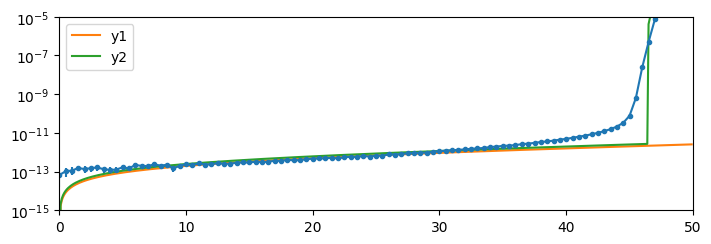

In [ ]:
def leakage_func(V, kBT = 25, Isat = 5e-14):
    return Isat * (np.exp(V/kBT) - 1 )

def breakdown_func(V, V01 = 44.5 , Isat = 5e-5):
    Ve = .7
    return 0.5 * (1+np.erf((V - V01)/Ve)) * leakage_func(V,kBT,Isat)

def breakdown_func2(V, V01 = 44, Isat = 5e-5):
    Rd = 24e3
    if(V < V01):
        return 0
    return (V - V01) / Rd 
    
def total_func(V, V01, kBT = 25, Isat_lk = 5e-14 , Isat_bd = 5e-5):
    return leakage_func(V,kBT,Isat_lk) + breakdown_func2(V, V01)

x = np.arange(0,50,0.1)
y1 = leakage_func(x,25,4e-13)
y2 = -leakage_func(-x,0.25,5e-13) #+ leakage_func(x,25,4e-13)

y2 = np.array([total_func(i, 46.4, 25, 5e-13, 5e-5)   for i in x])

V,I = arrays_from_db(db)
Ie = np.full_like(V,5e-14)
fig, ax = plt.subplots(layout='constrained', figsize=(7, 7/3))
ax.errorbar(V,I,Ie, fmt='.-')
ax.plot(x,y1, label = 'y1')
ax.plot(x,y2, label = 'y2')

ax.set_xlim(0,50)
ax.set_yscale('log')
ax.set_ylim(1e-15,1e-5)
ax.legend()
#fig.colorbar(cs)


In [ ]:
slicename, slice = dataset.filter(slicename='01E20', parameter="identifier", value='01E20')
dataset.clean_slice_data_rbias(target_slice_name=slicename, verbose=True)
slice = dataset.get_slice(target_slice_name = '01E10')

len target_slice 1341
Cleaning slice 01E20 with 1341 entries
Removing data_storage/Wafer_at_2025_06_23-11_51_07/Die_189/Subdie_18_ADiodes_1/IV_Die_189_Subdie_18_Diode_1,1_measurement_1.json from slice 01E20 due to insufficient number of rbias measurement-points (2)
Removing data_storage/Wafer_at_2025_06_23-11_51_07/Die_189/Subdie_18_ADiodes_1/IV_Die_189_Subdie_18_Diode_1,1_measurement_2.json from slice 01E20 due to insufficient number of rbias measurement-points (2)
Removing data_storage/Wafer_at_2025_06_23-11_51_07/Die_189/Subdie_18_ADiodes_1/IV_Die_189_Subdie_18_Diode_1,1_measurement_3.json from slice 01E20 due to insufficient number of rbias measurement-points (2)
Removing data_storage/Wafer_at_2025_06_23-11_51_07/Die_189/Subdie_18_ADiodes_1/IV_Die_189_Subdie_18_Diode_1,1_measurement_4.json from slice 01E20 due to insufficient number of rbias measurement-points (2)
len cleaned_t_s 1337
Yield of cleaned slice 01E20: 99.70%


ValueError: Slice '01E10' does not exist.

In [ ]:
#fig.clear()
#fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
for item, db in slice.items():
    #print(f"**** {item} ****")
    iv = db['iv_data_fbias']
    V,I = arrays_from_db(db,True,False)
    plt.semilogy(V,I)
plt

In [ ]:
plt.show()

## 3. Forward bias - Single item test

**** data_storage/Wafer_at_2025_06_23-11_51_07/Die_10/Subdie_18_ADiodes_1/IV_Die_10_Subdie_18_Diode_1,1_measurement_1.json ****
[2.04487484e-06 1.36695629e+01]


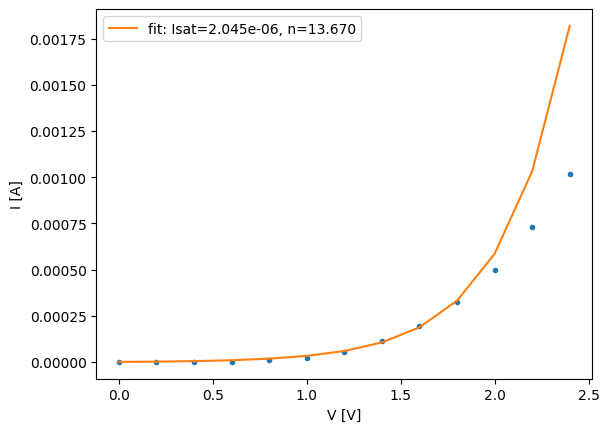

In [10]:
def diode_forward_func_Rs(V, Is=1e-12, n=3.0, Rs=0, T=300):
    kb = 8.617333262e-5

    """
    Calculate diode current I for each voltage V using the Shockley equation with series resistance.

    Parameters:
        V (array): Voltage values (in volts)
        Is (float): Saturation current (A)
        Rs (float): Series resistance (ohms)
        n (float): Ideality factor
        T (float): Temperature (Kelvin)

    Returns:
        I (array): Diode current values (in amps)
    """
    V = np.array(V)
    I = np.zeros_like(V)

    # Diode equation to solve: I = Is * (exp((q(V - I*Rs)) / (n k T)) - 1)
    def diode_eq(I, V_point):
        return Is * (np.exp((V_point - I * Rs) / (n * kb * T)) - 1) - I

    for i, V_point in enumerate(V):
        I[i] = fits.fsolve(diode_eq, x0=0, args=(V_point))[0]  # Initial guess = 0 A

    return I


def diode_forward_func(V, Is=1e-12, n=3.0, T=300):
    kb = 8.617333262e-5

    """
    Calculate diode current I for each voltage V using the Shockley equation with series resistance.

    Parameters:
        V (array): Voltage values (in volts)
        Is (float): Saturation current (A)
        n (float): Ideality factor
        T (float): Temperature (Kelvin)

    Returns:
        I (array): Diode current values (in amps)
    """
    return Is * (np.exp((V) / (n * kb * T)) - 1)
    

for item, db in slice.items():
    print(f"**** {item} ****")
    iv = db['iv_data_fbias']
    V,I = arrays_from_db(db,include_reverse=False, include_forward = True)
    V = -V
    I = -I
    break

popt = [1e-9,3]
popt, pcov = fits.curve_fit(f = diode_forward_func, xdata = V[V<2], ydata = I[V<2],
                p0 = popt, sigma = 1e-10, bounds = [[0,0.5], [1e-5,40]])
print(popt)
plt.plot(V, I, '.')
plt.plot(V, diode_forward_func(V,*popt), '-', label='fit: Isat=%5.3e, n=%5.3f' % tuple(popt))
plt.xlabel('V [V]')
plt.ylabel('I [A]')
plt.legend()
plt.show()

## 4. Forward bias - Fit all

In [47]:
for item, db in slice.items():
    #print(f"**** {item} ****")
    iv = db['iv_data_fbias']
    V,I = arrays_from_db(db,include_reverse=False, include_forward = True)
    V = -V
    I = -I
    popt = [1e-9,3]
    popt, pcov = fits.curve_fit(f = diode_forward_func, xdata = V[V<2], ydata = I[V<2],
                p0 = popt, sigma = 1e-10, bounds = [[0,0.5], [1e-5,40]])
    db['fit_f:Idsat']=popt[0]
    db['fit_f:n']=popt[1]
    try:
        db['eval_f:I(2.0)']=I[list(V).index(2)]
    except:
        db['eval_f:I(2.0)']=0

### Fit result distribution over wafer

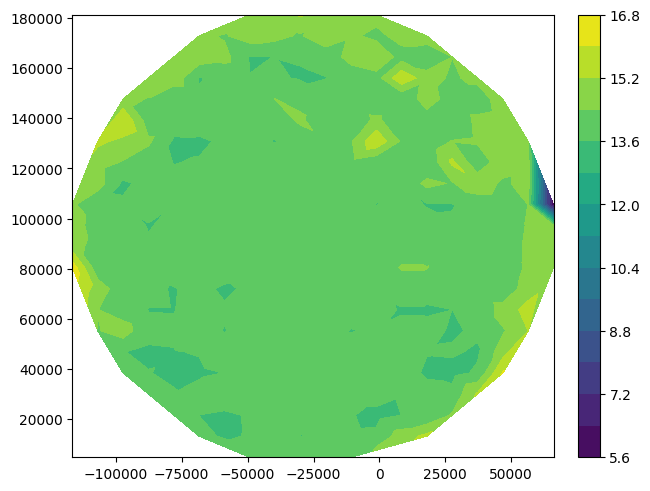

In [13]:
fig, ax = plt.subplots(layout='constrained')
x,y,c = np.transpose ([(float(db['x_pos']),float(db['y_pos']), float(db['fit_f:n'])) for item,db in slice.items()])
cs=plt.tricontourf(x,y,c,15)
fig.colorbar(cs)

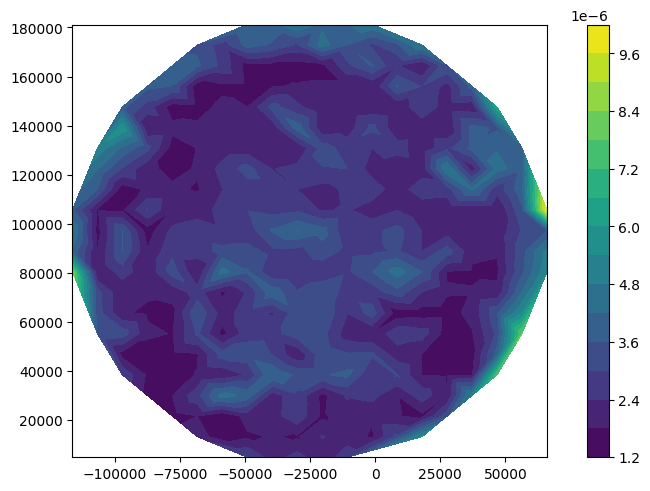

In [12]:
fig, ax = plt.subplots(layout='constrained')
x,y,c = np.transpose ([(float(db['x_pos']),float(db['y_pos']), float(db['fit_f:Idsat'])) for item,db in slice.items()])
cs = ax.tricontourf(x,y,c,15)
fig.colorbar(cs)

### Distribution of current at 2V forward bias

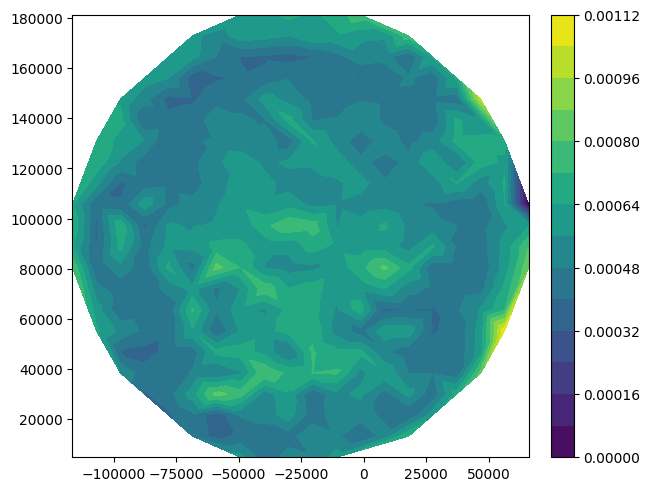

In [48]:
fig, ax = plt.subplots(layout='constrained')
x,y,c = np.transpose ([(float(db['x_pos']),float(db['y_pos']), float(db['eval_f:I(2.0)'])) for item,db in slice.items()])
cs=plt.tricontourf(x,y,c,15)
fig.colorbar(cs)

### Distribution of forward bias measurement points

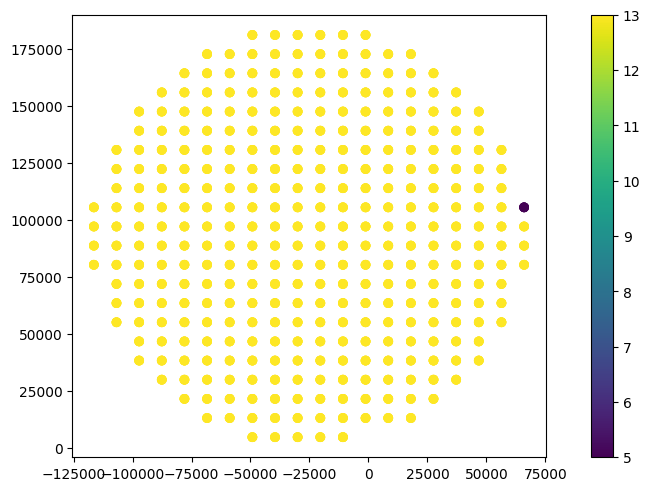

In [55]:
fig, ax = plt.subplots(layout='constrained')
x,y,c = np.transpose ([(float(db['x_pos']),float(db['y_pos']), len(db['iv_data_fbias'])) for item,db in slice.items()])
cs=plt.scatter(x,y,c=c)
fig.colorbar(cs)